In [ ]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid


!pip install torchsummary
from torchsummary import summary

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!ls /content/drive/

Mounted at /content/drive
MyDrive


In [ ]:
data_dir = "/content/drive/MyDrive/images data set/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [ ]:
# printing the disease names
print(diseases)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy', 'Apple___Cedar_apple_rust', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Raspberry___healthy', 'Strawberry___healthy', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___healthy', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Target_Spot', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato

In [ ]:
print(f"Total disease classes are: {len(diseases)}")


Total disease classes are: 37


In [ ]:
plants = set()
number_of_diseases = 0

for plant in diseases:
    plant_name, status = plant.split('___')
    plants.add(plant_name)
    if status != 'healthy':
        number_of_diseases += 1

# Unique plants in the dataset
print("Unique Plants are:")
for plant in plants:
    print(plant)


Unique Plants are:
Orange
Tomato
Peach
Blueberry
Apple
Squash
Potato
Cherry_(including_sour)
Strawberry
Grape
Corn_(maize)
Raspberry
Pepper,_bell


In [ ]:
# Number of unique diseases
print(f"Number of diseases: {number_of_diseases}")

Number of diseases: 26


In [ ]:
# Number of unique plants
print(f"Number of plants: {len(plants)}")


Number of plants: 13


In [ ]:
# Number of images for each disease
image_counts = {}
for disease in diseases:
    image_counts[disease] = len(os.listdir(train_dir + '/' + disease))

In [ ]:
# Converting the image_counts dictionary to a pandas dataframe
# Passing index as plant name and number of images as column
image_counts_df = pd.DataFrame(image_counts.values(), index=image_counts.keys(), columns=["number_of_images"])
image_counts_df

number_of_images
Apple___Apple_scab                                              2016
Apple___Black_rot                                               1987
Apple___healthy                                                  338
Apple___Cedar_apple_rust                                        1760
Corn_(maize)___Common_rust_                                     1907
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot              1642
Corn_(maize)___healthy                                          1859
Corn_(maize)___Northern_Leaf_Blight                             1914
Blueberry___healthy                                             1817
Cherry_(including_sour)___healthy                               1826
Cherry_(including_sour)___Powdery_mildew                        1683
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                      1722
Orange___Haunglongbing_(Citrus_greening)                        2010
Peach___Bacterial_spot                                          1844
Peach___healthy                                                 1728
Pepper,_bell___Bacterial_spot                                   1913
Pepper,_bell___healthy                                          1988
Grape___Black_rot                                               1888
Grape___Esca_(Black_Measles)                                    1920
Grape___healthy                                                 1692
Squash___Powdery_mildew                                         1736
Strawberry___Leaf_scorch                                        1774
Raspberry___healthy                                             1781
Strawberry___healthy                                            1830
Potato___Late_blight                                            1939
Potato___Early_blight                                           1939
Potato___healthy                                                1824
Tomato___healthy                                                1926
Tomato___Late_blight                                            1851
Tomato___Leaf_Mold                                              1882
Tomato___Target_Spot                                            1827
Tomato___Septoria_leaf_spot                                     1745
Tomato___Spider_mites Two-spotted_spider_mite                   1741
Tomato___Tomato_mosaic_virus                                    1790
Tomato___Tomato_Yellow_Leaf_Curl_Virus                          1963
Tomato___Early_blight                                           1920
Tomato___Bacterial_spot                                         1702

Text(0.5, 1.0, 'Images per Plant Disease Class')

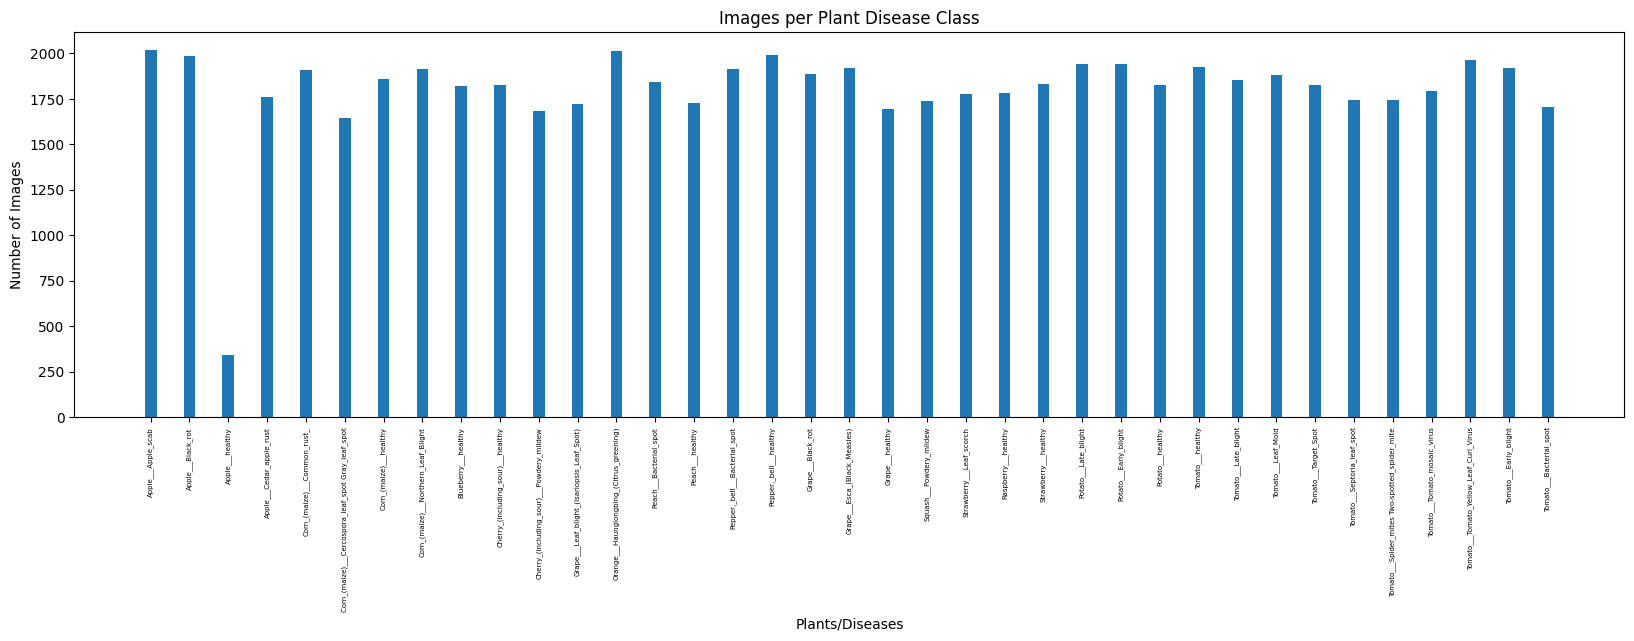

In [ ]:
# Plotting the number of images available for each disease
indices = [n for n in range(len(diseases))]
plt.figure(figsize=(20, 5))
plt.bar(indices, [n for n in image_counts.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('Number of Images', fontsize=10)
plt.xticks(indices, diseases, fontsize=5, rotation=90)
plt.title('Images per Plant Disease Class')

In [ ]:
# Calculating the total number of training images
total_train_images = sum(image_counts.values())
print(f"There are {total_train_images} images for training")

There are 66624 images for training


In [ ]:
# Creating datasets for training and validation
train_dataset = ImageFolder(train_dir, transform=transforms.ToTensor())
valid_dataset = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [ ]:
# Displaying the shape of an image and its label from the training dataset
image, label = train_dataset[0]
print(image.shape, label)


torch.Size([3, 256, 256]) 0


In [ ]:
# Getting the total number of classes in the training dataset
num_classes = len(train_dataset.classes)
print(f"Total number of classes in the training set: {num_classes}")

Total number of classes in the training set: 37


In [ ]:
# Function to display an image and its label
def show_image(image, label):
    print(f"Label: {train_dataset.classes[label]} ({label})")
    plt.imshow(image.permute(1, 2, 0))


Label: Apple___Apple_scab (0)


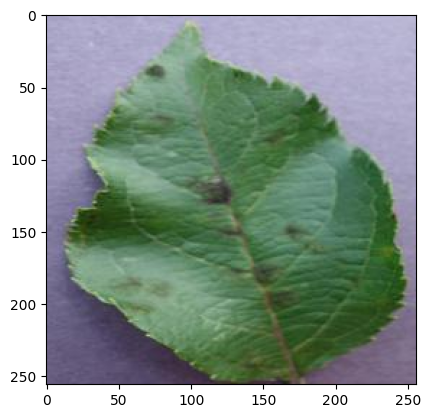

In [ ]:
# Displaying the first image and its label from the training dataset
show_image(*train_dataset[0])


Label: Tomato___Tomato_mosaic_virus (35)


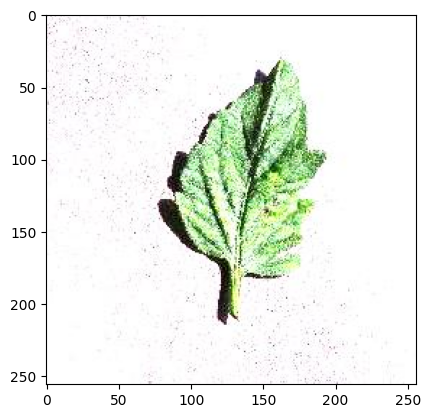

In [ ]:
show_image(*train_dataset[66000])

In [ ]:
# Setting the random seed value
random_seed = 7
torch.manual_seed(random_seed)

# Setting the batch size
batch_size = 32

In [ ]:
# DataLoaders for training and validation
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size, num_workers=2, pin_memory=True)

In [ ]:
# Helper function to show a batch of training instances
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


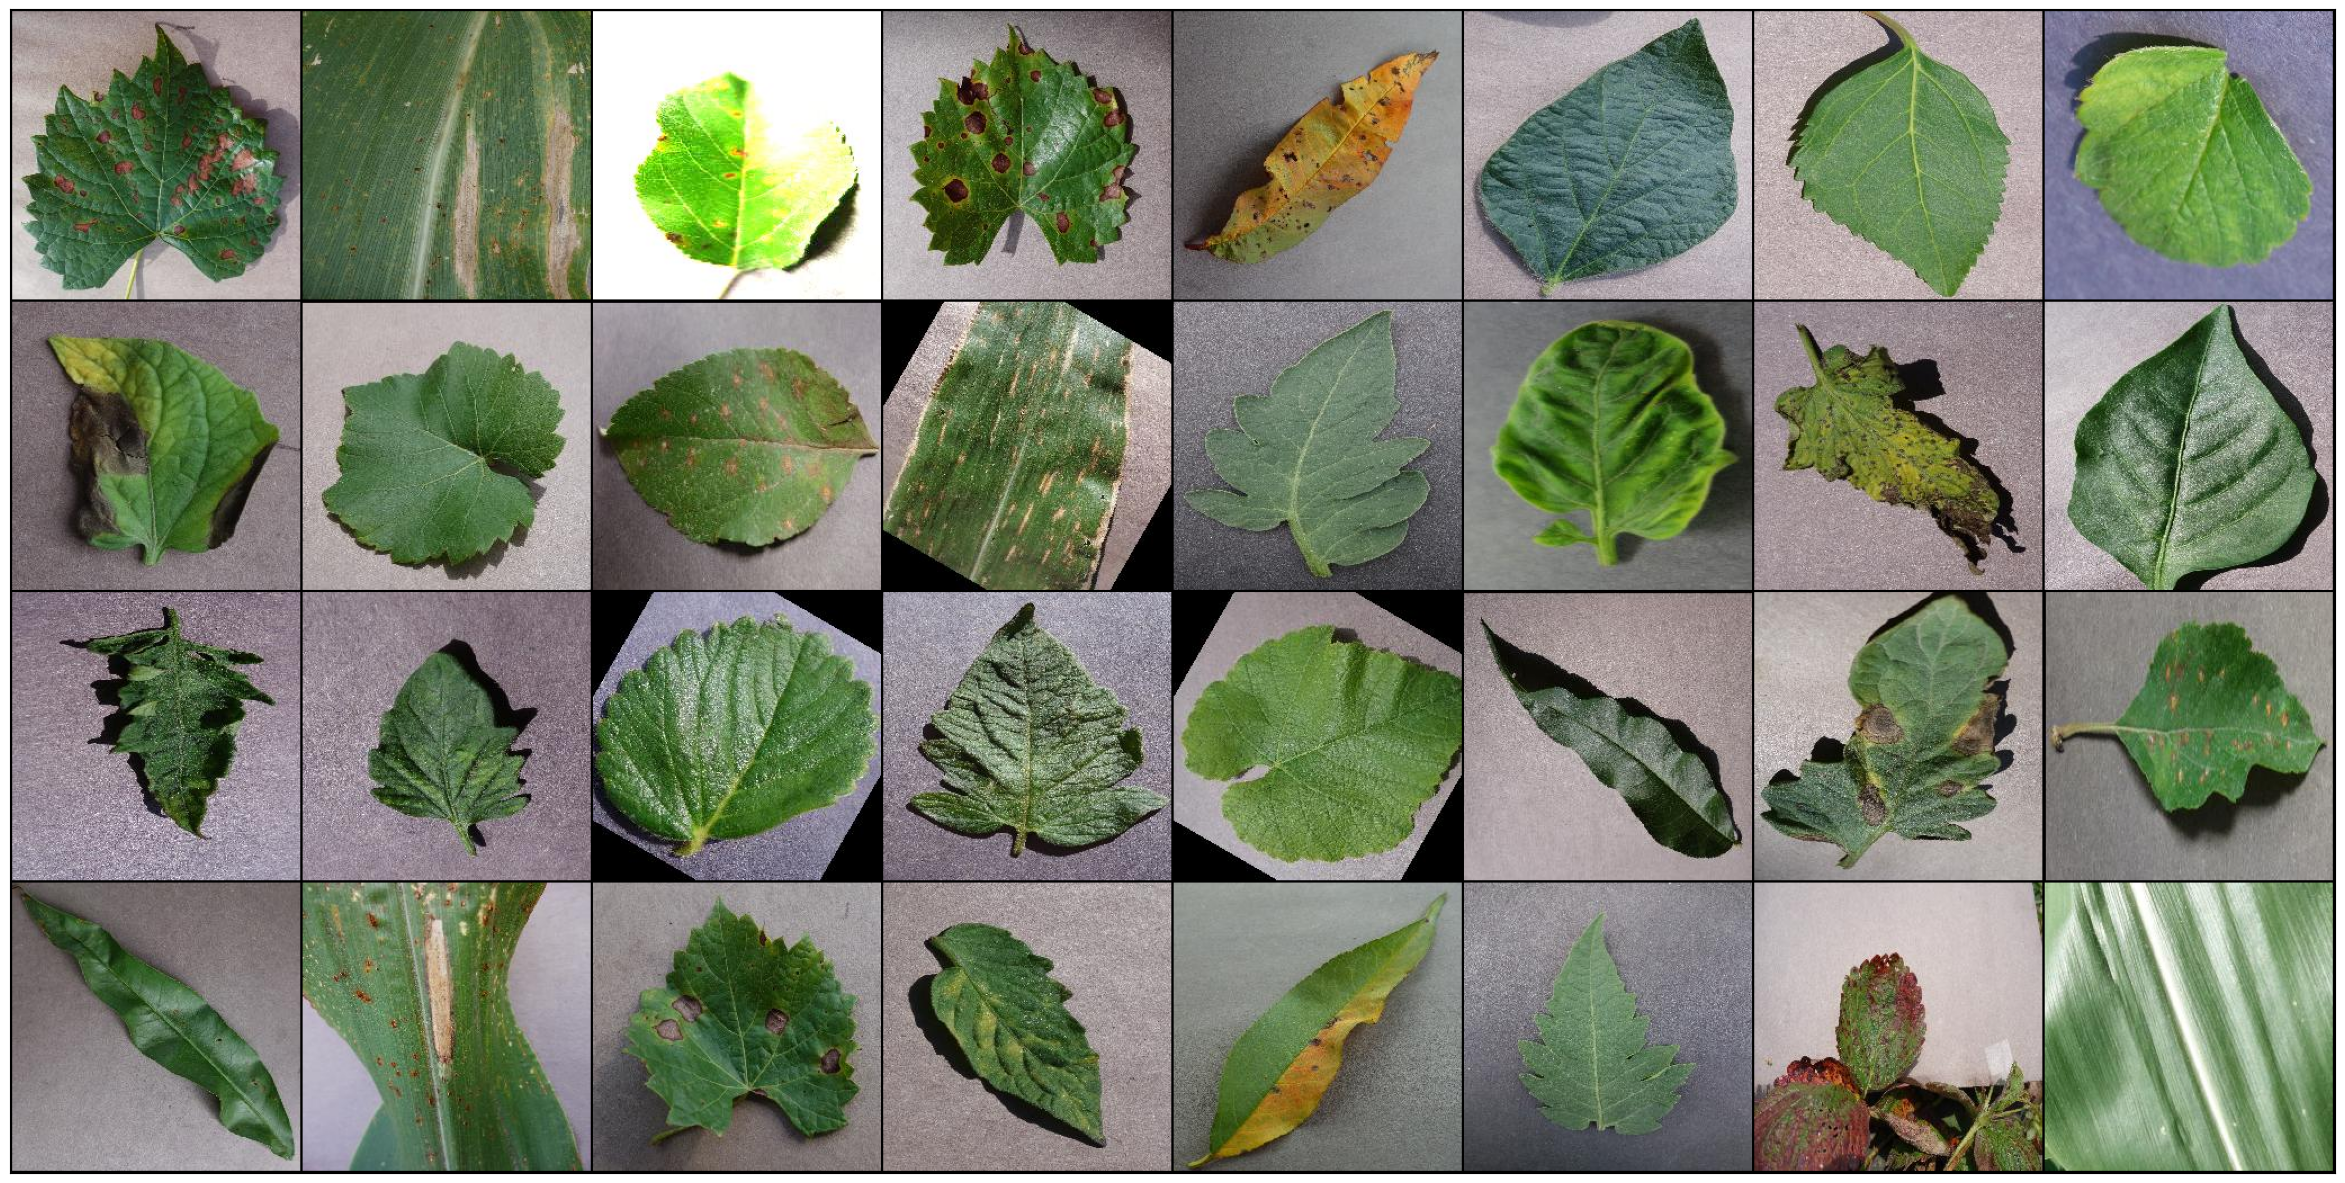

In [ ]:
# Images for the first batch of training
show_batch(train_dl)

In [ ]:
# Function to get the default device (GPU if available, else CPU)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [ ]:
# Function to move data to the device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to the chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


In [ ]:
# Class to wrap a dataloader to move data to a device
class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to the device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device


device(type='cuda')

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
# Simple Residual Block
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x  # ReLU can be applied before or after adding the input

In [ ]:
# Function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# Base class for the model
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
        epoch_accuracy = torch.stack(batch_accuracy).mean() # Combine accuracies
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [ ]:
# Convolution block with BatchNormalization
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

In [ ]:
# ResNet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)  # out_dim: 128 x 64 x 64
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)  # out_dim: 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True)  # out_dim: 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [ ]:
# Define the model and move it to GPU
model = to_device(ResNet9(3, len(train_dataset.classes)), device)
model


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# Get summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [ ]:
# Function for training
@torch.no_grad()
def evaluate_model(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                 grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Scheduler for one cycle learning rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record and update learning rates
            lrs.append(get_learning_rate(optimizer))
            sched.step()

        # Validation
        result = evaluate_model(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [ ]:
import torch
print(f"Device: {torch.cuda.get_device_name(0)}")
print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")
print(f"Available memory: {torch.cuda.memory_reserved(0) / (1024 ** 3):.2f} GB")

Device: Tesla T4
Total memory: 14.75 GB
Available memory: 0.31 GB


In [ ]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 44 s, sys: 3.28 s, total: 47.3 s
Wall time: 1min 32s


[{'val_loss': tensor(3.6397, device='cuda:0'), 'val_accuracy': tensor(0.0191)}]

In [ ]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 0.7466, val_loss: 0.5865, val_acc: 0.8319
Epoch [1], last_lr: 0.00000, train_loss: 0.1248, val_loss: 0.0269, val_acc: 0.9923
CPU times: user 11min 16s, sys: 7min 13s, total: 18min 30s
Wall time: 19min 53s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

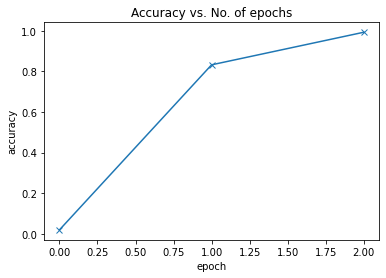

In [ ]:
plot_accuracies(history)

## Validation loss

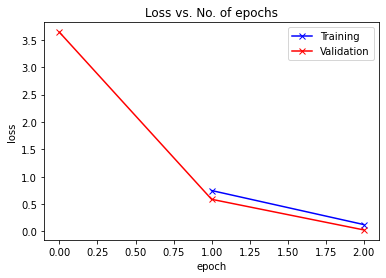

In [ ]:
plot_losses(history)

## Learning Rate overtime

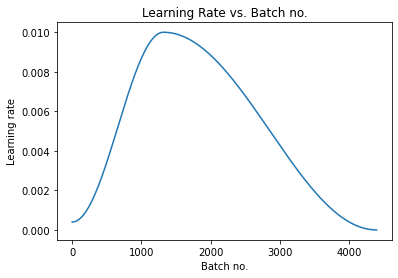

In [ ]:
plot_lrs(history)

In [ ]:
test_dir = "../input/new-plant-diseases-dataset/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [ ]:
test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [ ]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust


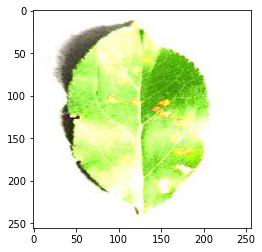

In [ ]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [ ]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___Apple_scab
Label: AppleScab2.JPG , Predicted: Apple___Apple_scab
Label: AppleScab3.JPG , Predicted: Apple___Apple_scab
Label: CornCommonRust1.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Common_rust_
Label: PotatoEarlyBlight1.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight2.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight3.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight4.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight5.JPG , Predicted: Potato___Early_blight
Label: PotatoHealthy1.JPG , Predicted: Potato___h

In [ ]:
# saving the entire model to working directory
PATH = '/content/drive/MyDrive/models/plant-disease-model.pth'
torch.save(model, PATH)